In [2]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

['dab1_guiyong.json', 'dab1_john.json', 'dab1_kelvin.json', 'dab1_xiaoxue.json', 'dab2_guiyong.json', 'dab2_john.json', 'dab2_kelvin.json', 'dab2_xiaoxue.json', 'dab2_yujie.json', 'elbowkick1_guiyong.json', 'elbowkick1_john.json', 'elbowkick1_kelvin.json', 'elbowkick1_xiaoxue.json', 'elbowkick2_guiyong.json', 'elbowkick2_john.json', 'elbowkick2_kelvin.json', 'elbowkick2_xiaoxue.json', 'elbowkick2_yujie.json', 'gun1_guiyong.json', 'gun1_john.json', 'gun1_kelvin.json', 'gun1_xiaoxue.json', 'gun2_guiyong.json', 'gun2_john.json', 'gun2_kelvin.json', 'gun2_xiaoxue.json', 'gun2_yujie.json', 'hair1_guiyong.json', 'hair1_john.json', 'hair1_kelvin.json', 'hair1_xiaoxue.json', 'hair2_guiyong.json', 'hair2_john.json', 'hair2_kelvin.json', 'hair2_xiaoxue.json', 'hair2_yujie.json', 'listen1_guiyong.json', 'listen1_john.json', 'listen1_kelvin.json', 'listen1_xiaoxue.json', 'listen2_guiyong.json', 'listen2_john.json', 'listen2_kelvin.json', 'listen2_xiaoxue.json', 'listen2_yujie.json', 'pointhigh1_gu

In [14]:
from sklearn import preprocessing
df_train = pd.read_csv('out_9_train.csv')
# df_train = df_train.iloc[:, list(range(15,55)) + [-1]]
df_test = pd.read_csv('out_9_test.csv')
# df_test = df_test.iloc[:, list(range(15,55)) + [-1]]

df_train['tag'] = df_train['tag'].apply(lambda x: x-1)
df_test['tag'] = df_test['tag'].apply(lambda x: x-1)

df_train.head()
# print(window_size, overlap)

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.753713,0.999632,0.470474,0.833865,-0.000759,0.181033,0.403467,0.0,9.0,0.00,...,0.450957,0.001794,0.201804,0.294856,0.0,4.0,0.17,0.445470,-0.811052,0.0
1,0.754843,0.999724,0.443404,0.856393,-0.002026,0.189315,0.395095,0.0,7.0,0.02,...,0.447967,0.002889,0.222927,0.443481,0.0,4.0,0.23,0.453868,-1.476090,0.0
2,0.708225,0.998650,0.479958,0.724127,0.000445,0.195004,0.404809,0.0,9.0,0.00,...,0.471292,0.000078,0.209378,0.376495,0.0,4.0,0.21,0.433665,-1.088357,0.0
3,0.714074,0.996962,0.473513,0.740378,-0.000208,0.186170,0.391735,0.0,7.0,0.00,...,0.480861,-0.000090,0.211063,0.380383,0.0,3.0,0.24,0.427733,-1.150881,0.0
4,0.711876,0.990117,0.461911,0.730265,0.003661,0.191240,0.401571,0.0,7.0,0.02,...,0.448565,0.000825,0.202586,0.311603,0.0,2.0,0.24,0.439468,-1.003944,0.0


In [15]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()

        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

50 55 60 65 70 75 80 85 90 95 100

In [16]:
dataset = FeatureDataset(df_train)
D_in = 72 # df.shape[1]-1
D_out = 3 # len(dances)
# df_train = df_train[:,:15]
# df_test = df_test[:,:15]

In [92]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Flatten

class CNN(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(CNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(in_channels=64,out_channels=64, kernel_size=5)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
#         self.conv4 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
#         self.conv5 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
#         self.lstm1 = torch.nn.LSTM(
#             input_size=14,
#             hidden_size=32,
#             num_layers=2,
#             batch_first=False,
#         )
        self.fc1 = torch.nn.Linear(60, 26)
        self.fc2 = torch.nn.Linear(26, d_out)
        
#         self.dropout = torch.nn.Dropout(p=0.3) 
        
    def forward(self,x):
        print("Init:", x.shape)
        x = x.float().unsqueeze(dim=1)
        print("Unsqueezed:", x.shape)
        # print(x)
        x = self.relu(self.conv1(x))
        # print(x)
        # x = self.dropout(x)
        x = self.relu(self.conv2(x))
        print(x.shape)
        # x = self.dropout(x)
        x = self.relu(self.conv3(x))
        print(x.shape)
        # x = self.dropout(x)
#         x = self.relu(self.conv4(x))
#         x = self.dropout(x)
#         x = self.relu(self.conv5(x))
#         x,_ = self.lstm1(x)
        x = x[:, -1]
        print(x.shape)
        x = self.relu(self.fc1(x))
        print(x.shape)
        # x = self.dropout(x)
        x = self.fc2(x)
        print(x.shape)
        return x
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [93]:
def train_val_model(model, criterion, optimizer, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=5, max_train_size=5000)
    kf = KFold(n_splits=10)
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.X.reshape(dataset.X.shape[0],-1), dataset.y, test_size=0.1, random_state=42
    )
    confusion_matrix = torch.zeros(8, 8)

    for i in range(num_epochs):
        if log_interval is not None and i % log_interval == 0:
            print('Epoch {}/{}'.format(i, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        # for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
        for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
            ### Dividing data into folds
            # train_index = train_index[len(train_index)-500:]
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(x_train_fold), end='\t\t')
            print('Test Index Length:', len(x_test_fold), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 20, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 20, shuffle = False)

            running_loss = 0.0
            running_corrects = 0
            model.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                for t, p in zip(y_batch.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
                single_loss = criterion(y_pred, y_batch.long().view(-1))
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , kf.get_n_splits(X_train), i + 1, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and i % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return model, losses, accuracies

In [94]:
model = CNN(D_in, 64, D_out)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([64, 1, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([26, 60])
torch.Size([26])
torch.Size([3, 26])
torch.Size([3])
Total number of parameters = 43139


In [95]:
NUM_EPOCHS = 4
model, losses, accuracies = train_val_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, log_interval=1)

Epoch 0/3
----------
Train Index Length: 259		Test Index Length: 29

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1

torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([19, 72])
Unsqueezed: torch.Size([19, 1, 72])
torch.Size([19, 64, 64])
torch.Size([19, 64, 60])
torch.Size([19, 60])
torch.Size([19, 26])
torch.Size([19, 3])
Fold No. 4/10	Epoch 1/4	loss: 0.37615079
val Loss: 0.6745 Acc: 74.52%
Train Index Length: 259		Test Index Length: 29

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.S

torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.S

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([19, 72])
Unsqueezed: torch.Size([19, 1, 72])
torch.Size([19, 64, 64])
torch.Size([19, 64, 60])
torch.Size([19, 60])
torch.Size([19, 26])
torch.Size([19, 3])
Fold No. 5/10	Epoch 2/4	loss: 0.01666524
val Loss: 0.0875 Acc: 97.30%
Train Index Length: 259		Test Index Length: 29

Init: t

torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed:

torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed:

Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([19, 72])
Unsqueezed: torch.Size([19, 1, 72])
torch.Size([19, 64, 64])
torch.Size([19, 64, 60])
torch.Size([19, 60])
torch.Size([19, 26])
torch.Size([19, 3])
Fold No. 6/10	Epoch 3/4	loss: 0.00554661
val Loss: 0.0518 Acc: 98.46%
Train Index Length: 259		Test Index Length: 29

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsquee

torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 6

torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.S

torch.Size([19, 64, 60])
torch.Size([19, 60])
torch.Size([19, 26])
torch.Size([19, 3])
Fold No. 7/10	Epoch 4/4	loss: 0.00251673
val Loss: 0.0527 Acc: 98.46%
Train Index Length: 259		Test Index Length: 29

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.S

In [96]:
NUM_EPOCHS = 15
overlap = 48
window_size = 50

In [97]:
name = f'CNN_Model_moves_{D_out}_ws{window_size}_ol{overlap}_epoch{NUM_EPOCHS}'
torch.save(model.state_dict(), name)

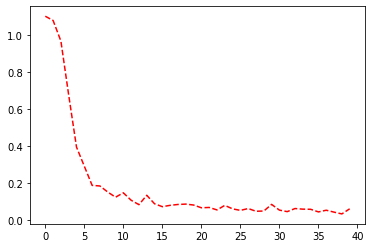

In [98]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [101]:
cnn_model = CNN(D_in, 70, D_out)
cnn_model.load(name)
cnn_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = cnn_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

Init: torch.Size([20, 72])
Unsqueezed: torch.Size([20, 1, 72])
torch.Size([20, 64, 64])
torch.Size([20, 64, 60])
torch.Size([20, 60])
torch.Size([20, 26])
torch.Size([20, 3])
{0: 0.85, 2: 0.1, 1: 0.05}
Init: torch.Size([22, 72])
Unsqueezed: torch.Size([22, 1, 72])
torch.Size([22, 64, 64])
torch.Size([22, 64, 60])
torch.Size([22, 60])
torch.Size([22, 26])
torch.Size([22, 3])
{1: 0.9090909090909091, 0: 0.045454545454545456, 2: 0.045454545454545456}
Init: torch.Size([22, 72])
Unsqueezed: torch.Size([22, 1, 72])
torch.Size([22, 64, 64])
torch.Size([22, 64, 60])
torch.Size([22, 60])
torch.Size([22, 26])
torch.Size([22, 3])
{2: 1.0}


In [102]:
def feature_extract(df, window_size):
    full_features = np.array([])
    axis = ['accel1', 'accel2', 'accel3', 'gyro1', 'gyro2', 'gyro3']
    titles = np.ravel(np.array([i+'_'+j for i in feature_list for j in axis]))

    # print("Begin Feature Extraction")
    windows = set_sliding_windows(df, 75, window_size)
    # windows = set_windows(df, window_size)

    for window in windows:
        for _,ax in enumerate(window.T):
                full_features = np.append(full_features, add_mean(ax))
                full_features = np.append(full_features, add_max(ax))
                full_features = np.append(full_features, add_min(ax))
                full_features = np.append(full_features, add_median(ax))
                full_features = np.append(full_features, add_gradient(ax))
                full_features = np.append(full_features, add_std(ax))
                full_features = np.append(full_features, add_iqr(ax))
                # full_features = np.append(full_features, add_skew(ax))
                full_features = np.append(full_features, add_zero_crossing_count(ax))
                # full_features = np.append(full_features, add_cwt(ax))
                full_features = np.append(full_features, add_no_peaks(ax))
                full_features = np.append(full_features, add_recurring_dp(ax))
                # full_features = np.append(full_features, add_ratio_v_tsl(ax))
                # full_features = np.append(full_features, add_sum_recurring_dp(ax))
                full_features = np.append(full_features, add_var_coeff(ax))
                full_features = np.append(full_features, add_kurtosis(ax)) 

    full_features = full_features.reshape(
        -1,
        len(feature_list) * 6,
    )   
    full_features_df = pd.DataFrame(full_features)
    full_features_df.columns = titles
    return full_features_df

def feature_extraction(data):
    data = pd.DataFrame.from_dict(data)
    if 'dance' in data:
        del data['dance']

    df = data.apply(pd.to_numeric).interpolate(method='polynomial', order=2)
    col = df.columns
    # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)
    df_scaled = df.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    # min_max_scaler = preprocessing.MinMaxScaler()
    # df_scaled = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=col)
    df.reset_index(drop=True, inplace=True)

    print(df.shape)
    features = feature_extract(df, window_size=80).reset_index(drop=True)
    # print(features.shape)
    return features

In [103]:
import json

cnn_model = CNN(D_in, 70, 3)
cnn_model.load('CNN_Model_moves_3_ws50_ol48_epoch15')
cnn_model.eval()

# dances = ['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh', 'sidepump', 'wipetable']
dances = ['gun', 'hair', 'sidepump']
# dances = ['elbowkick', 'pointhigh', 'wipetable']
persons = ['kelvin', 'guiyong', 'xiaoxue', 'john']
beetles = ['1', '2']

test_range = 12
leap = 100
truth, total, skipped = 0,0,0
for i in range(18,18+test_range):
    print("Phase:", i)
    start, end = i * leap, i * leap + leap
    for d in dances:
        print(d)
        df_full = pd.DataFrame()
        collection = [np.array([]) for x in range(16)]
        j = 0
        for p in persons:
            for b in beetles:
                if b == '1':
                    continue
                move_json = 'collected_data/' + d + b + '_' + p + '.json'
                with open(move_json) as f:
                    x = json.load(f)
                x = pd.DataFrame.from_dict(x)[start:end]
                df_target = torch.from_numpy(np.array(feature_extraction(x)))
                output = cnn_model.predict(df_target)
                proba_dict = {}

                for x in output:
                    x = int(x)
                    if x not in proba_dict:
                        proba_dict[x] = 1
                    else:
                        proba_dict[x] += 1
                for k in proba_dict.keys():
                    proba_dict[k] /= len(output)

                print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

Phase: 18
gun
(100, 6)
Set sliding windows: 5
Sliding: 0
Init: torch.Size([5, 72])
Unsqueezed: torch.Size([5, 1, 72])
torch.Size([5, 64, 64])
torch.Size([5, 64, 60])
torch.Size([5, 60])
torch.Size([5, 26])
torch.Size([5, 3])
{0: 1.0}
(100, 6)
Set sliding windows: 5
Sliding: 0
Init: torch.Size([5, 72])
Unsqueezed: torch.Size([5, 1, 72])
torch.Size([5, 64, 64])
torch.Size([5, 64, 60])
torch.Size([5, 60])
torch.Size([5, 26])
torch.Size([5, 3])
{0: 1.0}
(100, 6)
Set sliding windows: 5
Sliding: 0
Init: torch.Size([5, 72])
Unsqueezed: torch.Size([5, 1, 72])
torch.Size([5, 64, 64])
torch.Size([5, 64, 60])
torch.Size([5, 60])
torch.Size([5, 26])
torch.Size([5, 3])
{0: 1.0}
(100, 6)
Set sliding windows: 5
Sliding: 0
Init: torch.Size([5, 72])
Unsqueezed: torch.Size([5, 1, 72])
torch.Size([5, 64, 64])
torch.Size([5, 64, 60])
torch.Size([5, 60])
torch.Size([5, 26])
torch.Size([5, 3])
{0: 1.0}
hair
(100, 6)
Set sliding windows: 5
Sliding: 0
Init: torch.Size([5, 72])
Unsqueezed: torch.Size([5, 1, 72

RuntimeError: cannot perform reduction function max on tensor with no elements because the operation does not have an identity

In [ ]:
dataset.df.head()